#PREDICTION OF INSURANCE PREMIUM

##Installations

In [1]:
!pip install lazypredict
!pip install xgboost
!pip install lightgbm

##Importing files

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,KFold

In [4]:
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import GradientBoostingRegressor

##Exploratory data analysis

In [5]:
#LOADING DATASET
insurance_df=pd.read_csv('/content/DS3_C6_S1_Regression_Insurance_Data_Project.csv')
print(insurance_df.shape)
insurance_df.tail()

(1338, 8)


,age,sex,bmi,classif,children,smoker,region,charges
1333,50,male,30.97,OB1,3,no,northwest,10600.55
1334,18,female,31.92,OB1,0,no,northeast,2205.98
1335,18,female,36.85,OB2,0,no,southeast,1629.83
1336,21,female,25.80,PREO,0,no,southwest,2007.94
1337,-1,female,29.07,PREO,0,yes,northwest,29141.36


In [6]:
#CHECKING FOR NULL VALUES AND DATA TYPES OF COLUMNS
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   classif   1330 non-null   object 
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [7]:
#REPLACING NULL VALUES IN CLASSIF COLUMN
max=insurance_df.groupby(by=['classif'])['bmi'].max()
min=insurance_df.groupby(by=['classif'])['bmi'].min()
minmax=pd.DataFrame([min,max])
minmax=minmax.T
minmax.columns=['Min','Max']
minmax['Classif']=minmax.index
minmax

,Min,Max,Classif
classif,,,
N,18.50,25.00,N
OB1,30.00,34.96,OB1
OB2,35.09,39.99,OB2
OB3,40.15,53.13,OB3
PREO,25.08,29.93,PREO
UW,15.96,18.34,UW


In [8]:
rows_with_nan = []
for index, row in insurance_df.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)
print(rows_with_nan)

[15, 74, 128, 173, 559, 671, 839, 1331]


In [9]:
for i in rows_with_nan:
  value=insurance_df['bmi'].iloc[i]
  a1=minmax[(minmax['Min']<=value)& (minmax['Max']>=value)]
  classi=a1['Classif'][0]
  insurance_df['classif'].iloc[i]=classi

In [10]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   classif   1338 non-null   object 
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [11]:
#DESCRIBING THE DATASET
insurance_df.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.13,30.66,1.09,13270.42
std,14.96,6.10,1.21,12110.01
min,-58.00,15.96,0.00,1121.87
25%,26.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,190.00,53.13,5.00,63770.43


In [12]:
#REMOVING ROWS WITH AGE LESS THAN 0 AND GREATER THAN 100
insurance_df=insurance_df[(insurance_df.age>0)&(insurance_df.age<100)].reset_index()
insurance_df.drop(columns=['index'],inplace=True)
print(insurance_df.shape)
print(insurance_df.tail(2))
insurance_df.describe()

(1333, 8)
      age     sex   bmi classif  children smoker     region  charges
1331   18  female 36.85     OB2         0     no  southeast  1629.83
1332   21  female 25.80    PREO         0     no  southwest  2007.94


,age,bmi,children,charges
count,1333.00,1333.00,1333.00,1333.00
mean,39.18,30.66,1.10,13262.76
std,14.03,6.08,1.21,12118.56
min,18.00,15.96,0.00,1121.87
25%,27.00,26.32,0.00,4738.27
50%,39.00,30.40,1.00,9361.33
75%,51.00,34.70,2.00,16586.50
max,64.00,53.13,5.00,63770.43


In [13]:
insurancee_df=insurance_df.copy()
#OUTLIER TREATMENT
print('ROWS AND COLUMNS BEFORE REMOVING OUTLIERS:',insurancee_df.shape)
print()
def myoutliers(df,col):
    
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    UF=Q3+1.5*IQR
    LF=Q1-1.5*IQR
    
    print('LOWER RANGE OF',col,'IS',LF)
    print('UPPER RANGE OF',col,'IS',UF)
    
    mylist=[x for x in df[col] if((x<LF) | (x>UF))]
    print('TOTAL OUTLIERS IN',col,'ARE',len(mylist))
    my_outlier_df=df.loc[df[col].isin(mylist)]
    
for i in ['age','children','bmi','charges']:
    print('I is', i)
    myoutliers(insurancee_df, i)
    Index=my_outlier_df.index
    insurancee_df=insurancee_df.drop(Index)
    print("************************************")
print()
print('ROWS AND COLUMNS AFTER REMOVING OUTLIERS:',insurancee_df.shape,'\n')

ROWS AND COLUMNS BEFORE REMOVING OUTLIERS: (1333, 8)

I is age
LOWER RANGE OF age IS -9.0
UPPER RANGE OF age IS 87.0
TOTAL OUTLIERS IN age ARE 0
************************************
I is children
LOWER RANGE OF children IS -3.0
UPPER RANGE OF children IS 5.0
TOTAL OUTLIERS IN children ARE 0
************************************
I is bmi
LOWER RANGE OF bmi IS 13.737499999999999
UPPER RANGE OF bmi IS 47.2775
TOTAL OUTLIERS IN bmi ARE 8
************************************
I is charges
LOWER RANGE OF charges IS -13020.99875
UPPER RANGE OF charges IS 34337.04645
TOTAL OUTLIERS IN charges ARE 138
************************************

ROWS AND COLUMNS AFTER REMOVING OUTLIERS: (1187, 8) 



we are not going to do outlier treatment on CHARGES column as it may affect the accuracy of the model

In [14]:
#GETTING ONLY NUMERIC COLUMNS
insurance_df_numeric=insurance_df.select_dtypes('number')
insurance_df_numeric.tail(2)

,age,bmi,children,charges
1331,18,36.85,0,1629.83
1332,21,25.80,0,2007.94


In [15]:
#GETTING ONLY CATEGORICAL COLUMNS
insurance_df_categorical=insurance_df.select_dtypes('object')
insurance_df_categorical.tail(2)

,sex,classif,smoker,region
1331,female,OB2,no,southeast
1332,female,PREO,no,southwest


In [16]:
#COLUMNS NAMES
print('Numeric columns:',insurance_df_numeric.columns)
print('Categorical columns:',insurance_df_categorical.columns)

Numeric columns: Index(['age', 'bmi', 'children', 'charges'], dtype='object')
Categorical columns: Index(['sex', 'classif', 'smoker', 'region'], dtype='object')


###UNIVARIATE ANALYSIS

####UNIVARIATE ANALYSIS FOR CATEGORICAL DATA

In [17]:
for i in insurance_df_categorical.columns:
  print(i)
  print(insurance_df[i].value_counts())

sex
male      673
female    660
Name: sex, dtype: int64
classif
OB1     390
PREO    382
N       226
OB2     225
OB3      90
UW       20
Name: classif, dtype: int64
smoker
no     1060
yes     273
Name: smoker, dtype: int64
region
southeast    363
southwest    325
northeast    323
northwest    322
Name: region, dtype: int64


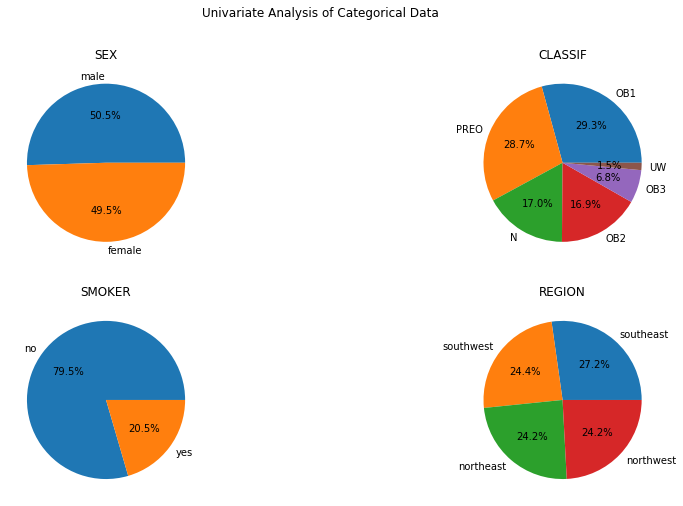

In [18]:
cat=list(enumerate(insurance_df_categorical.columns))
plt.figure(figsize=(15,8))
for i in cat:
    plt.subplot(2,2,i[0]+1)                      
    d= insurance_df[i[1]].value_counts()                                                                                                    
    labels =d.keys()      
    plt.pie(x = d, autopct = "%.1f%%", labels = labels)
    plt.title(i[1].upper())
plt.suptitle('Univariate Analysis of Categorical Data')
plt.show()

Region and Sex does not affect data much,while smoker and classif column may affect the evaluation

####UNIVARIATE ANALYSIS FOR NUMERICAL DATA

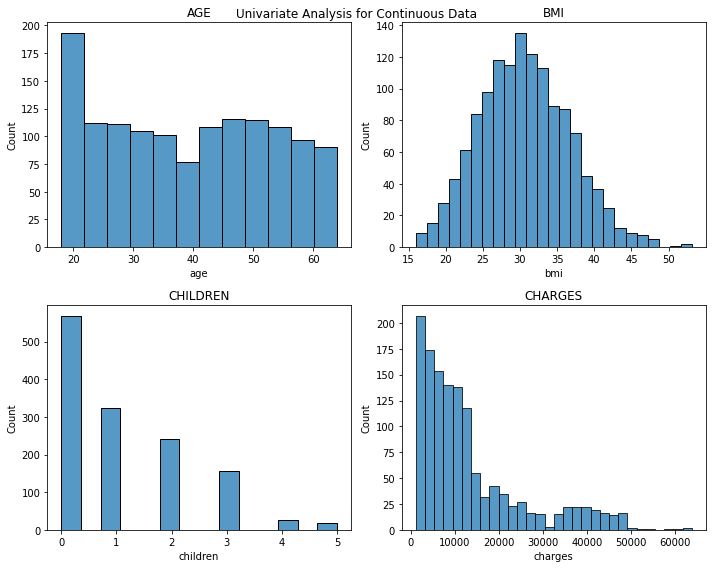

In [19]:
n=list(enumerate(insurance_df_numeric.columns))
plt.figure(figsize=(10,8))
for i in n:
    plt.subplot(2,2,i[0]+1)
    sns.histplot(x=i[1],data=insurance_df)
    plt.title(i[1].upper())
plt.suptitle('Univariate Analysis for Continuous Data')
plt.tight_layout()
plt.show()

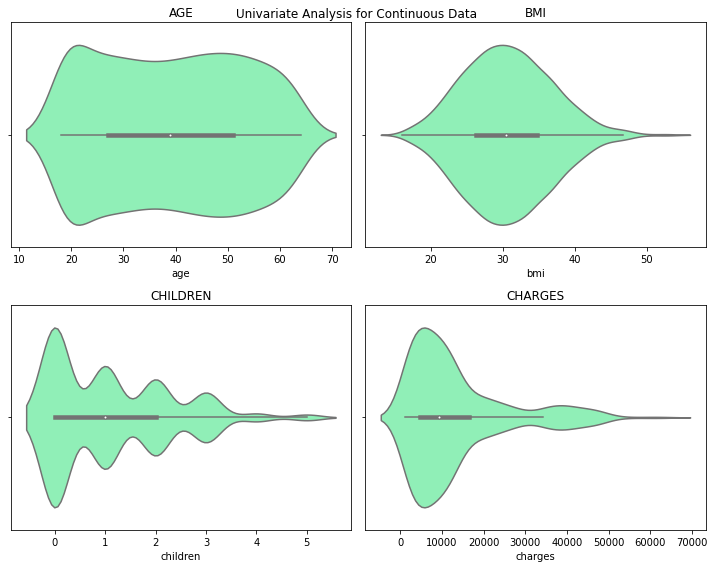

In [20]:
n=list(enumerate(insurance_df_numeric.columns))
plt.figure(figsize=(10,8))
for i in n:
    plt.subplot(2,2,i[0]+1)
    sns.violinplot(x=i[1],data=insurance_df,palette='rainbow')
    plt.title(i[1].upper())
plt.suptitle('Univariate Analysis for Continuous Data')
plt.tight_layout()
plt.show()

All the numerical data are not normally distributed and they are right skewed

###BIVARIATE ANALYSIS

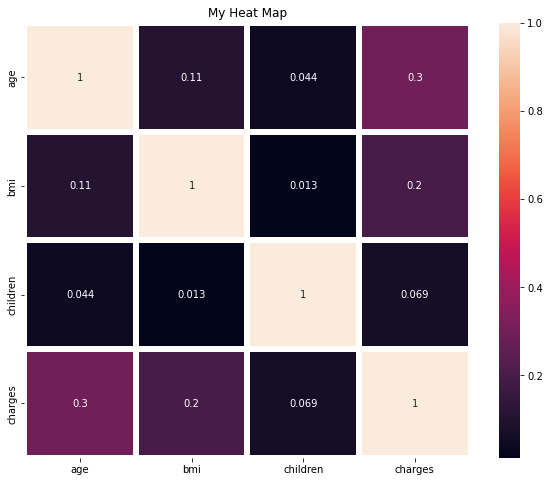

In [21]:
#FINDING RELATIONSHIP BETWEEN COLUMNS FOR BIVARIATE ANALYSIS
plt.figure(figsize=(10,8))
sns.heatmap(insurance_df.corr(),annot=True,linewidth=5).set_title('My Heat Map')
plt.show()

Categorical: sex Numerical: age


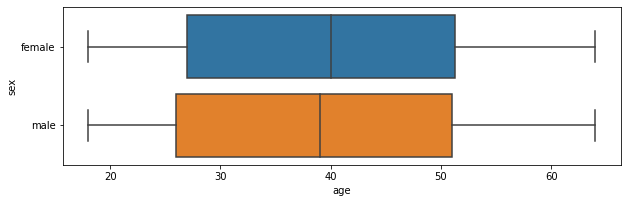

Categorical: sex Numerical: bmi


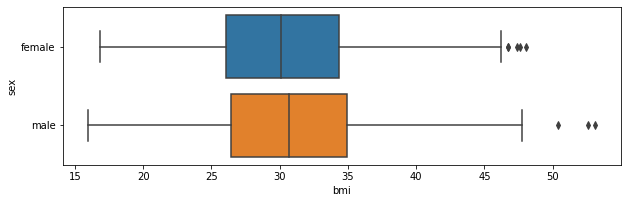

Categorical: sex Numerical: children


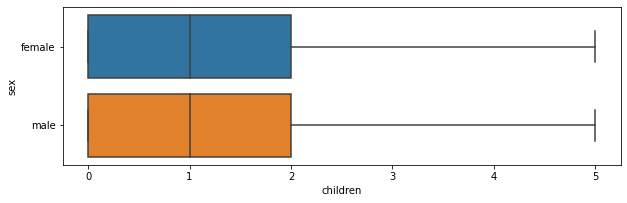

Categorical: sex Numerical: charges


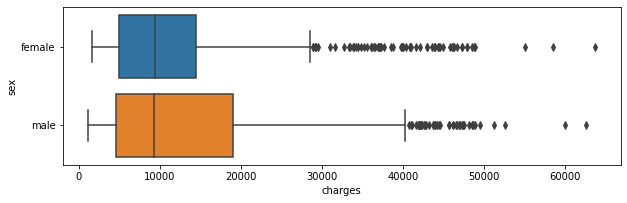

Categorical: classif Numerical: age


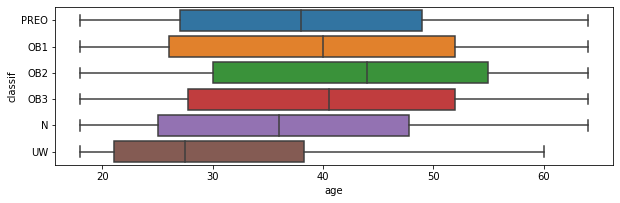

Categorical: classif Numerical: bmi


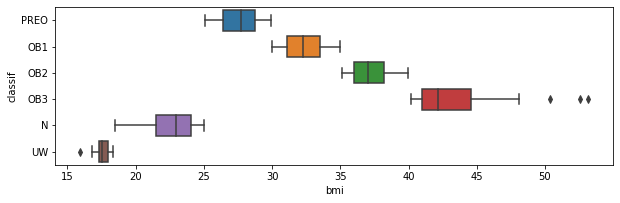

Categorical: classif Numerical: children


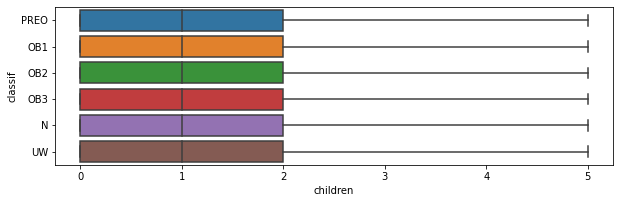

Categorical: classif Numerical: charges


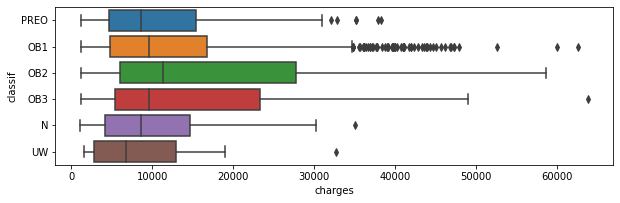

Categorical: smoker Numerical: age


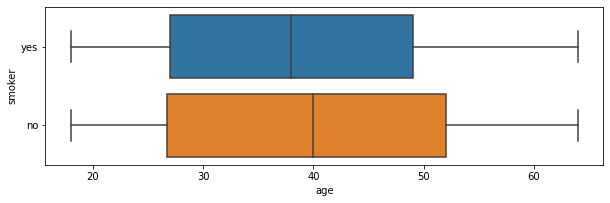

Categorical: smoker Numerical: bmi


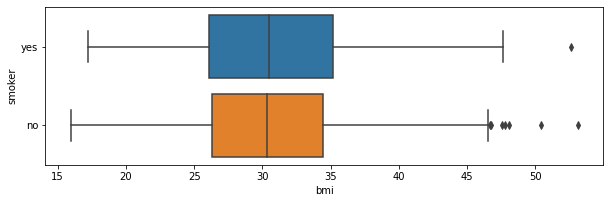

Categorical: smoker Numerical: children


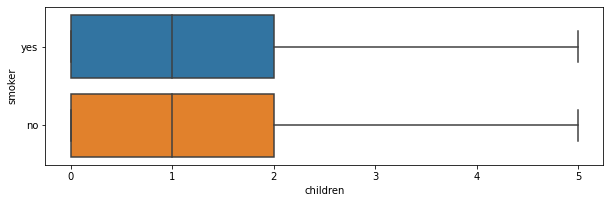

Categorical: smoker Numerical: charges


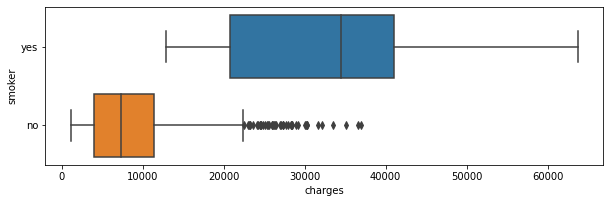

Categorical: region Numerical: age


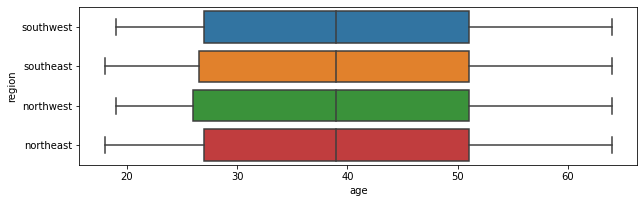

Categorical: region Numerical: bmi


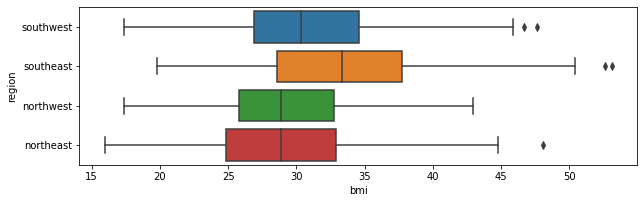

Categorical: region Numerical: children


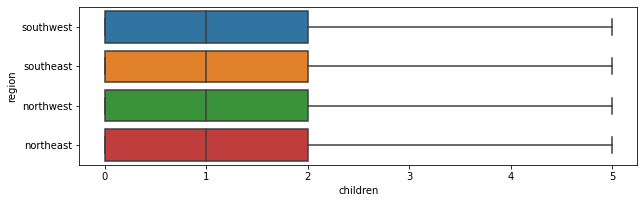

Categorical: region Numerical: charges


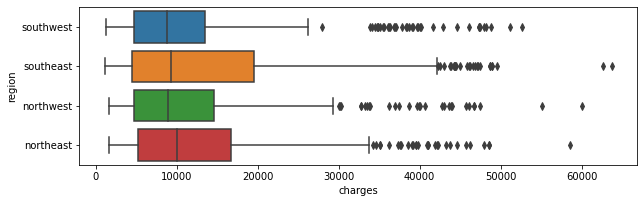

In [22]:
#CATEGORICAL TO NUMERICAL
for i in insurance_df_categorical.columns:
  for j in insurance_df_numeric.columns:
    print('Categorical:',i,'Numerical:',j)
    plt.figure(figsize = (10,2.9))
    sns.boxplot(x = j, y =i , data = insurance_df)
    plt.show()

In [23]:
insurance_df.groupby(by=['smoker'])['age'].mean()

smoker
no    39.38
yes   38.43
Name: age, dtype: float64

**CONCLUSION:from bivariate analysis**

*1)Region column does not affect much the children,age,charges, and a little of bmi*

*2)Classif column does not affect children, but we cannot see the diffenece in other 3 columns*

*3)Sex column does not affect children,age,charges,bmi*

*4)Smoker column does not affect children, but it direcly affects the charges*

sex VS classif


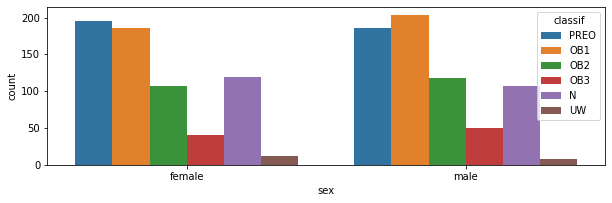

sex VS smoker


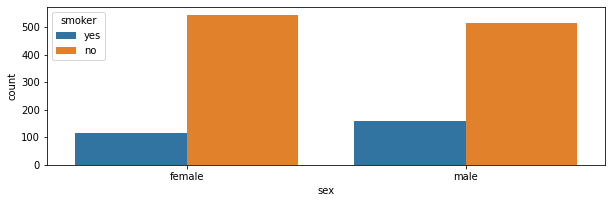

sex VS region


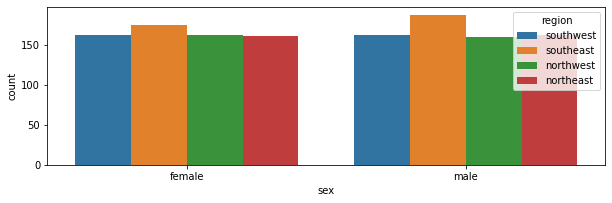

classif VS sex


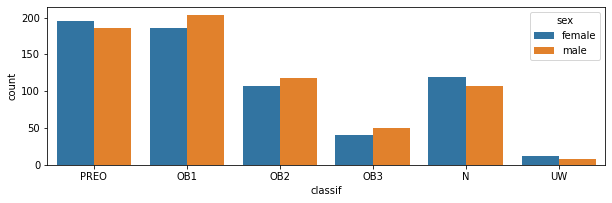

classif VS smoker


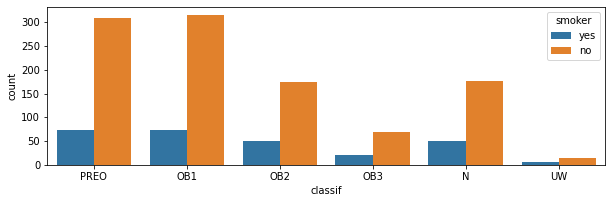

classif VS region


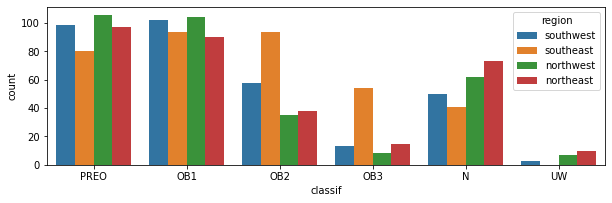

smoker VS sex


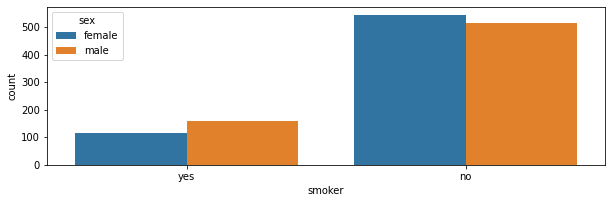

smoker VS classif


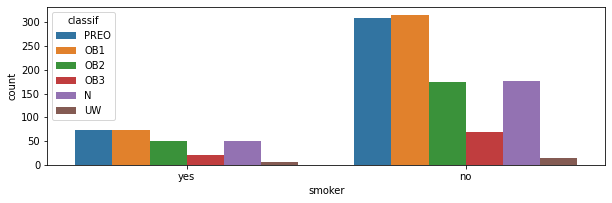

smoker VS region


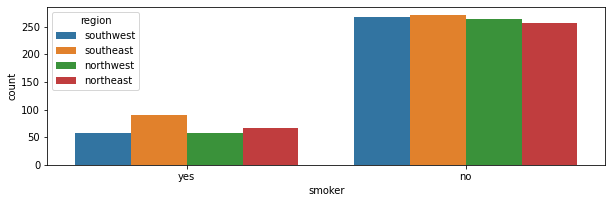

region VS sex


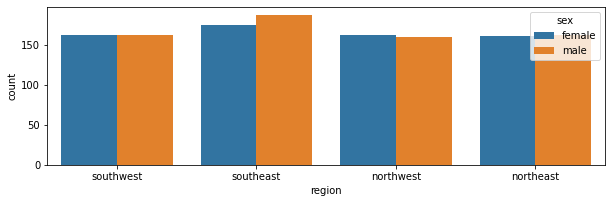

region VS classif


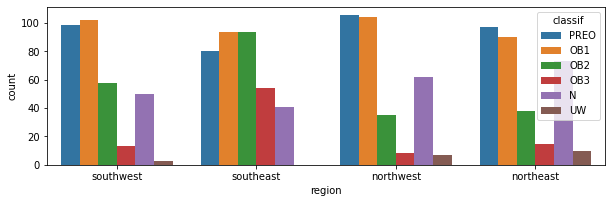

region VS smoker


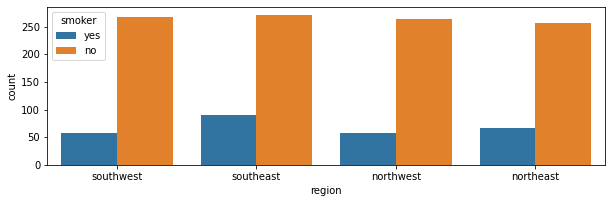

In [24]:
#CATEGORICAL TO CATEGORICAL
for i in insurance_df_categorical.columns:
  for j in insurance_df_categorical.columns:
    if i!=j:
      print(i,'VS',j)
      plt.figure(figsize = (10,2.9))    
      sns.countplot(x = i, hue = j, data = insurance_df)
      plt.show()

**CONCLUSION:-**

*1)Sex does not affect the data*

*2)More number of smokers are from PREO and OB1 - classif*

*3)Region and smoker affects the classif*

##Data preprocessing

In [25]:
#CREATING DUMMIES FOR CATEGORICAL DATA
insurance_df3=pd.get_dummies(insurance_df)
print(insurance_df3.shape)
insurance_df3.tail(2)

(1333, 18)


,age,bmi,children,charges,sex_female,sex_male,classif_N,classif_OB1,classif_OB2,classif_OB3,classif_PREO,classif_UW,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1331,18,36.85,0,1629.83,1,0,0,0,1,0,0,0,1,0,0,0,1,0
1332,21,25.80,0,2007.94,1,0,0,0,0,0,1,0,1,0,0,0,0,1


In [26]:
insurance_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1333 non-null   int64  
 1   bmi               1333 non-null   float64
 2   children          1333 non-null   int64  
 3   charges           1333 non-null   float64
 4   sex_female        1333 non-null   uint8  
 5   sex_male          1333 non-null   uint8  
 6   classif_N         1333 non-null   uint8  
 7   classif_OB1       1333 non-null   uint8  
 8   classif_OB2       1333 non-null   uint8  
 9   classif_OB3       1333 non-null   uint8  
 10  classif_PREO      1333 non-null   uint8  
 11  classif_UW        1333 non-null   uint8  
 12  smoker_no         1333 non-null   uint8  
 13  smoker_yes        1333 non-null   uint8  
 14  region_northeast  1333 non-null   uint8  
 15  region_northwest  1333 non-null   uint8  
 16  region_southeast  1333 non-null   uint8  


##Data preparation

In [27]:
insurance_df3.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'classif_N', 'classif_OB1', 'classif_OB2', 'classif_OB3',
       'classif_PREO', 'classif_UW', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [28]:
#Splitting targets and features
y=insurance_df3[['charges']]
X=insurance_df3.drop(columns=['charges'])
X.shape,y.shape

((1333, 17), (1333, 1))

In [29]:
#Defining function for random splits and state
def state_split(size,state):
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=size,random_state=state)
  clf=LazyRegressor(verbose=0,ignore_warnings=True,custom_metric=None)
  models,predictions=clf.fit(X_train,X_test,y_train,y_test) 
  return models.iloc[:5]

##Modelling

####Model selection
**selecting GradientBoostingRegressor model**

In [30]:
state_split(0.1,50)

100%|██████████| 42/42 [00:14<00:00,  2.88it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.79,0.82,5617.07,0.27
AdaBoostRegressor,0.78,0.81,5685.44,0.08
RandomForestRegressor,0.78,0.80,5778.33,0.98
HistGradientBoostingRegressor,0.77,0.80,5853.23,2.29
LGBMRegressor,0.76,0.79,6029.25,0.31


In [31]:
state_split(0.1,110)

100%|██████████| 42/42 [00:12<00:00,  3.43it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.90,0.91,3511.91,0.36
RandomForestRegressor,0.88,0.90,3776.89,0.91
LGBMRegressor,0.88,0.90,3806.34,0.37
HistGradientBoostingRegressor,0.88,0.89,3835.82,1.54
ExtraTreesRegressor,0.88,0.89,3883.89,0.87


In [32]:
state_split(0.2,7)

100%|██████████| 42/42 [00:05<00:00,  7.41it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.88,0.89,4276.82,0.17
LGBMRegressor,0.87,0.88,4499.18,0.08
HistGradientBoostingRegressor,0.87,0.88,4564.92,0.55
RandomForestRegressor,0.87,0.87,4619.98,0.41
BaggingRegressor,0.86,0.86,4790.59,0.11


In [33]:
state_split(0.2,110)

100%|██████████| 42/42 [00:05<00:00,  8.28it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.85,0.86,4293.16,0.18
RandomForestRegressor,0.85,0.86,4328.60,0.41
LGBMRegressor,0.84,0.85,4470.21,0.08
HistGradientBoostingRegressor,0.84,0.85,4535.28,0.44
ExtraTreesRegressor,0.84,0.85,4537.75,0.37


In [34]:
state_split(0.2,50)

100%|██████████| 42/42 [00:04<00:00,  8.63it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.82,0.83,5041.15,0.16
AdaBoostRegressor,0.81,0.82,5172.82,0.03
RandomForestRegressor,0.81,0.82,5176.07,0.42
BaggingRegressor,0.80,0.81,5338.12,0.05
HistGradientBoostingRegressor,0.79,0.81,5405.50,0.42


###GradientBoostingRegressor

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)
# X_train.shape,X_test.shape,y_train.shape,y_test.shape
for i in range(100,200,10):  
  gbr_params = {'n_estimators': i,
            'max_depth': 2,
            'min_samples_split': 5,
            'learning_rate': 0.1,
            'loss': 'ls'}
  gbr = GradientBoostingRegressor(**gbr_params)
  gbr.fit(X_train, y_train)
  #define cross-validation method to use
  cv = KFold(n_splits=2, random_state=7) 
  #evaluate model
  score = cross_val_score(gbr, X, y, scoring='r2',
                          cv=cv, n_jobs=-1)
  print('Overall accuracy of the model with n_estimator',i,'=',round(np.mean(abs(score)),2)*100,'%')

Overall accuracy of the model with n_estimator 100 = 86.0 %
Overall accuracy of the model with n_estimator 110 = 86.0 %
Overall accuracy of the model with n_estimator 120 = 86.0 %
Overall accuracy of the model with n_estimator 130 = 86.0 %
Overall accuracy of the model with n_estimator 140 = 86.0 %
Overall accuracy of the model with n_estimator 150 = 86.0 %
Overall accuracy of the model with n_estimator 160 = 86.0 %
Overall accuracy of the model with n_estimator 170 = 86.0 %
Overall accuracy of the model with n_estimator 180 = 86.0 %
Overall accuracy of the model with n_estimator 190 = 86.0 %


In [36]:
gbr_params = {'n_estimators': 200,
            'max_depth': 2,
            'min_samples_split': 5,
            'learning_rate': 0.1,
            'loss': 'ls'}
gbr = GradientBoostingRegressor(**gbr_params)

In [37]:
#FITTING TRAINING AND PREDICTING
gbr.fit(X_train,y_train)
Prediction2 = gbr.predict(X_test)
print("R-Squared on test dataset=",(round(gbr.score(X_test,y_test),2)*100),'%')
print('MSE of the test data=',round(mean_squared_error(Prediction2,y_test),2))

R-Squared on test dataset= 89.0 %
MSE of the test data= 18137708.24


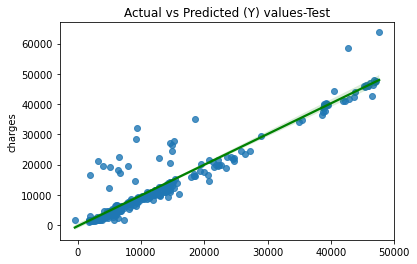

In [38]:
sns.regplot(Prediction2,y_test, line_kws={"color": "green"})
plt.title('Actual vs Predicted (Y) values-Test')
plt.show()

we can see the accuracy of test data is 89% and we are going to use the model to predict the whole dataset charges value

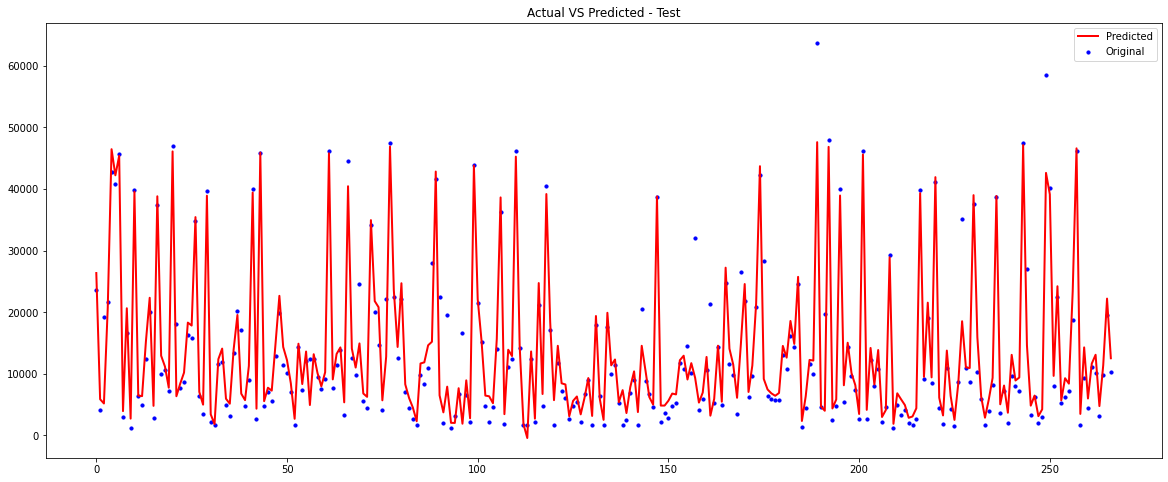

In [39]:
#VISUALIZING ORIGINAL VS PREDICTED VALUES
x_ax=range(len(y_test))
plt.figure(figsize=(20,8))
plt.scatter(x_ax,y_test,s=10,color='blue',label='Original')
plt.plot(x_ax,Prediction2,lw=2.0,color='red',label='Predicted')
plt.legend()
plt.title('Actual VS Predicted - Test')
plt.show()

In [40]:
#CHECKING FOR OVER FITTING
gbr1= GradientBoostingRegressor(**gbr_params)
gbr1.fit(X_test,y_test)
Prediction1 = gbr1.predict(X_train)
print("R-Squared on train dataset=",(round(gbr1.score(X_train,y_train),2)*100),'%')
print('MSE of the train data=',round(mean_squared_error(Prediction1,y_train),2))

R-Squared on train dataset= 82.0 %
MSE of the train data= 25406955.16


The model is not overfitted

##Predictions for whole dataset

In [41]:
pred=gbr.predict(X)
pred=pred.reshape(1333,1)
print(pred.shape)
pred1=gbr.predict(X_test)
pred1=pred1.reshape(267,1)
print(pred1.shape)

(1333, 1)
(267, 1)


In [42]:
actual=np.array(y).reshape(-1,1)
print(actual.shape)
actual1=np.array(y_test).reshape(-1,1)
print(actual1.shape)

(1333, 1)
(267, 1)


In [43]:
diff=actual-pred
print(diff.shape)
diff1=actual1-pred1
print(diff1.shape)

(1333, 1)
(267, 1)


In [44]:
print('Accuracy of model for whole dataset=',round(gbr.score(X,y),2)*100,'%')

Accuracy of model for whole dataset= 89.0 %


In [45]:
#WHOLE DATASET
data= np.concatenate((actual,pred,diff),axis=1)
data=pd.DataFrame(data,columns=['Actual_charge','Predicted_charge','Diff_in_charge'])
data.head(2)

,Actual_charge,Predicted_charge,Diff_in_charge
0,16884.92,19188.53,-2303.61
1,1725.55,3513.08,-1787.53


In [46]:
#TEST DATASET
data_test= np.concatenate((actual1,pred1,diff1),axis=1)
data_test=pd.DataFrame(data_test,columns=['Actual_charge','Predicted_charge','Diff_in_charge'])
print(data_test.shape)
data_test.head(2)

(267, 3)


,Actual_charge,Predicted_charge,Diff_in_charge
0,23568.27,26365.29,-2797.02
1,4151.03,5871.55,-1720.52


##Inference

In [47]:
#WHOLE DATASET
insurance_DF=insurance_df.copy()
insurance_DF.reset_index()
insurance_DF['predicted_charges']=data['Predicted_charge']
insurance_DF['diff_in_charges']=data['Diff_in_charge']
insurance_DF.head(2)

,age,sex,bmi,classif,children,smoker,region,charges,predicted_charges,diff_in_charges
0,19,female,27.90,PREO,0,yes,southwest,16884.92,19188.53,-2303.61
1,18,male,33.77,OB1,1,no,southeast,1725.55,3513.08,-1787.53


In [48]:
insurance_DF.describe()

,age,bmi,children,charges,predicted_charges,diff_in_charges
count,1333.00,1333.00,1333.00,1333.00,1333.00,1333.00
mean,39.18,30.66,1.10,13262.76,13292.27,-29.51
std,14.03,6.08,1.21,12118.56,11237.33,3992.02
min,18.00,15.96,0.00,1121.87,-427.95,-6109.29
25%,27.00,26.32,0.00,4738.27,5953.69,-1662.89
50%,39.00,30.40,1.00,9361.33,9844.21,-1010.52
75%,51.00,34.70,2.00,16586.50,14690.86,-350.65
max,64.00,53.13,5.00,63770.43,48762.03,22746.91


In [49]:
#WHOLE DATASET
insurance_testDF=insurance_df.copy()
insurance_testDF=insurance_testDF.iloc[y_test.index].reset_index()
insurance_testDF.drop(columns=['index'],inplace=True)
insurance_testDF['predicted_charges']=data_test['Predicted_charge']
insurance_testDF['diff_in_charges']=data_test['Diff_in_charge']
print(insurance_testDF.shape)
insurance_testDF.tail(2)

(267, 10)


,age,sex,bmi,classif,children,smoker,region,charges,predicted_charges,diff_in_charges
265,44,female,20.23,N,1,yes,northeast,19594.81,22214.06,-2619.25
266,55,male,29.90,PREO,0,no,southwest,10214.64,12525.93,-2311.29


In [50]:
insurance_testDF.describe()

,age,bmi,children,charges,predicted_charges,diff_in_charges
count,267.00,267.00,267.00,267.00,267.00,267.00
mean,38.37,30.98,1.12,13668.33,13815.67,-147.35
std,13.61,6.77,1.27,13035.04,12131.66,4264.28
min,18.00,15.96,0.00,1146.80,-427.95,-6109.29
25%,26.00,26.31,0.00,4666.57,5780.57,-1818.61
50%,39.00,30.78,1.00,9361.33,9361.75,-1130.19
75%,50.00,35.22,2.00,18049.99,14991.83,-391.41
max,64.00,52.58,5.00,63770.43,47616.27,22746.91


In [51]:
insurance_testDF.to_csv('testData.csv',index= False)
ddf=pd.read_csv('testData.csv')
ddf

,age,sex,bmi,classif,children,smoker,region,charges,predicted_charges,diff_in_charges
0,48,male,28.00,PREO,1,yes,southwest,23568.27,26365.29,-2797.02
1,30,female,33.33,OB1,1,no,southeast,4151.03,5871.55,-1720.52
2,37,male,36.19,OB2,0,no,southeast,19214.71,5183.61,14031.10
3,39,female,24.89,N,3,yes,northeast,21659.93,20711.76,948.17
4,45,male,36.48,OB2,2,yes,northwest,42760.50,46475.38,-3714.87
...,...,...,...,...,...,...,...,...,...,...
262,53,male,30.50,OB1,0,no,northeast,10072.06,13093.64,-3021.58
263,28,female,33.11,OB1,0,no,southeast,3171.61,4760.22,-1588.60
264,52,male,47.74,OB3,1,no,southeast,9748.91,11383.65,-1634.74
265,44,female,20.23,N,1,yes,northeast,19594.81,22214.06,-2619.25


In [52]:
insurance_DF.to_csv('wholeData.csv',index= False)
ddf1=pd.read_csv('wholeData.csv')
ddf1

,age,sex,bmi,classif,children,smoker,region,charges,predicted_charges,diff_in_charges
0,19,female,27.90,PREO,0,yes,southwest,16884.92,19188.53,-2303.61
1,18,male,33.77,OB1,1,no,southeast,1725.55,3513.08,-1787.53
2,28,male,33.00,OB1,3,no,southeast,4449.46,5798.85,-1349.39
3,32,male,28.88,PREO,0,no,northwest,3866.86,4094.43,-227.58
4,31,female,25.74,PREO,0,no,southeast,3756.62,4692.45,-935.83
...,...,...,...,...,...,...,...,...,...,...
1328,52,female,44.70,OB3,3,no,southwest,11411.68,12201.28,-789.59
1329,50,male,30.97,OB1,3,no,northwest,10600.55,11797.78,-1197.23
1330,18,female,31.92,OB1,0,no,northeast,2205.98,3247.41,-1041.42
1331,18,female,36.85,OB2,0,no,southeast,1629.83,3347.17,-1717.33


By reference with these files,we can predict insurance costs for future

In [53]:
DATA=[22,25,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00]
L=[]
for i in range(0,17):
  L1=(X.columns[i],DATA[i])
  L.append(L1)
L=dict(L);
M=pd.DataFrame(L.values()).T
M.columns=L.keys()
M

,age,bmi,children,sex_female,sex_male,classif_N,classif_OB1,classif_OB2,classif_OB3,classif_PREO,classif_UW,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,22.00,25.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [54]:
X.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'classif_N',
       'classif_OB1', 'classif_OB2', 'classif_OB3', 'classif_PREO',
       'classif_UW', 'smoker_no', 'smoker_yes', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [55]:
gbr.predict(M)

array([2829.51621001])